In [1]:
import tensorflow as tf
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
# os.environ['CUDA_VISIBLE_DEVICES']='1,2,3'
import gc
import keras.backend as K
from keras import Input
import numpy as np
from keras.layers import MaxPooling2D, UpSampling2D, Conv2D, Dropout,Concatenate,BatchNormalization
from keras.models import Model, load_model
from util import getdatset, cclt_psnr
%matplotlib inline
import matplotlib.pyplot as plt

train_xh,test_xh,train_xl,test_xl = getdatset(1000,1000)
#print(train_xh.shape[0])
#print(train_xl.shape[0])
#print(test_xh.shape[0])
#print(test_xl.shape[0])

def myKLD(y_true,y_pred):
    y_true = K.clip(y_true,1,255)
    y_pred = K.clip(y_pred,1,255)
    u=y_true
    f=y_pred
    KLD = K.sum((f / K.sqrt(u) * K.log (f / u) - f / K.sqrt(u) + K.sqrt(u)),axis=-1)
    return KLD

/opt/software/anaconda/3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
def CNN1(input_img,num_layers):
    x = Conv2D(64,(3,3),padding='same',activation = 'relu')(input_img)
    for i in range(num_layers):
        x = Conv2D(64,(3,3),padding='same',activation='relu')(x)
        x = BatchNormalization(axis=1)(x)
    y = Conv2D(1,(3,3),padding='same')(x)
    CNN = Model(input_img,y)
    CNN.compile(optimizer='adam',loss='mse')
    return CNN

num_CNN_layers = 10
Epoch = 50
tmp_input = Input(shape=(128,128,1), name='tmp_input')
tmp_model = CNN1(tmp_input,num_CNN_layers)
history=tmp_model.fit(train_xl,train_xh,epochs=Epoch,batch_size=8,shuffle=True,verbose=1,validation_data=(test_xl, test_xh))

Train on 1000 samples, validate on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 46s 46ms/step - loss: 6536.8292 - val_loss: 3052.7202
Epoch 2/50
1000/1000 [==============================] - 44s 44ms/step - loss: 1257.0189 - val_loss: 671.7768
Epoch 3/50
1000/1000 [==============================] - 44s 44ms/step - loss: 537.4247 - val_loss: 357.6892
Epoch 4/50
1000/1000 [==============================] - 44s 44ms/step - loss: 349.2629 - val_loss: 451.5533
Epoch 5/50
1000/1000 [==============================] - 44s 44ms/step - loss: 287.3884 - val_loss: 236.2377
Epoch 6/50
1000/1000 [==============================] - 44s 44ms/step - loss: 238.6670 - val_loss: 477.3434
Epoch 7/50
1000/1000 [==============================] - 44s 44ms/step - loss: 204.7415 - val_loss: 158.2632
Epoch 8/50
1000/1000 [==============================] - 44s 44ms/step - loss: 187.7303 - val_loss: 170.2438
Epoch 9/50
1000/1000 [==============================] - 44s 44ms/step - loss: 191.195

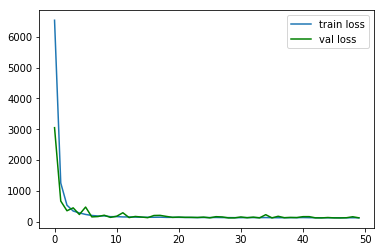

In [11]:
import pylab as pl
pl.figure()
pl.plot(history.history['loss'], label='train loss')
pl.plot(history.history['val_loss'], c='g', label='val loss')
pl.legend()

In [12]:
tmp_model.save("CNN10_MSE_0601.h5")
tmp_model.save_weights("CNN10_MSE_0601w.h5")

In [13]:
from skimage.measure import compare_psnr, compare_ssim
test_xd = tmp_model.predict(test_xl)
N = test_xh.shape[0]
denoise_imgs = np.reshape(test_xd,(N,128,128))
ori_imgs = np.reshape(test_xh,(N,128,128))
noisy_imgs = np.reshape(test_xl,(N,128,128))
PSNR_noisy=[]
PSNR_denoise=[]
SSIM_noisy = []
SSIM_denoise = []
for img_index in range(N):
    ori_img = ori_imgs[img_index]
    noisy_img = noisy_imgs[img_index]
    float_type = np.result_type(ori_img.dtype, noisy_img.dtype, np.float32)
    ori_img = ori_img.astype(float_type)
    noisy_img = noisy_img.astype(float_type)
    denoise_img = denoise_imgs[img_index]
    psnr_noise, psnr_denoised = compare_psnr(ori_img, noisy_img,data_range=255), compare_psnr(ori_img,denoise_img,data_range=255)
    ssim_noise, ssim_denoised = compare_ssim(ori_img, noisy_img), compare_ssim(ori_img, denoise_img)
    SSIM_noisy.append(ssim_noise)
    SSIM_denoise.append(ssim_denoised)
    PSNR_noisy.append(psnr_noise)
    PSNR_denoise.append(psnr_denoised)

print("Average PSNR before denoising:",sum(PSNR_noisy)/N)
print("Average PSNR after denoising:",sum(PSNR_denoise)/N)
print("Average SSIM before denoising:",sum(SSIM_noisy)/N)
print("Average SSIM after denoising:",sum(SSIM_denoise)/N)  

Average PSNR before denoising: 22.372600475223454
Average PSNR after denoising: 27.107431536303103
Average SSIM before denoising: 0.7476365234938761
Average SSIM after denoising: 0.8753756951360641
